# Crée une calculatrice avec un algorithme de Deep Learning

## 1. Importations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import random

## 2. Configuration du matériel

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

if torch.cuda.is_available():
    print("Le GPU est utilisé")
else:
    print("Le GPU n'est PAS utilisé, le CPU est utilisé")

Le GPU est utilisé


## 3. Fonction de création du jeu de données

In [3]:
def create_calculator_dataset(num_samples, min_value, max_value, operation):
    X = np.random.randint(min_value, max_value+1, (num_samples, 2))
    if operation == 'add':
        y = X[:, 0] + X[:, 1]
    elif operation == 'multiply':
        y = X[:, 0] * X[:, 1]
    else:
        raise ValueError("Operation not recognized. Use 'add' or 'multiply'")
    X = X / max_value
    if operation == 'add':
        y = y / (2 * max_value)
    elif operation == 'multiply':
        y = y / (max_value * max_value)
    return X, y

## 4. Architecture du réseau

In [4]:
class MLP(nn.Module):
    def __init__(self, input_size=2, hidden_size=40, output_size=1, num_hidden_layers=4):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList([nn.Linear(input_size, hidden_size)])
        self.layers.extend([nn.Linear(hidden_size, hidden_size) for _ in range(num_hidden_layers-1)])
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        for layer in self.layers:
            x = torch.relu(layer(x))
        x = self.output_layer(x)
        return x

## 5. Fonctions d'entraînement et de préparation

In [5]:
# Fonction de création du DataLoader
def create_calculator_dataloader(num_samples=1000, min_value=0, max_value=10, operation='add', batch_size=64):
    X, y = create_calculator_dataset(num_samples, min_value, max_value, operation)
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y, dtype=torch.float32).to(device)
    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

# Fonction pour obtenir l'optimiseur
def get_optimizer(model, optimizer_name="adam", lr=0.001):
    if optimizer_name.lower() == "adam":
        return torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name.lower() == "sgd":
        return torch.optim.SGD(model.parameters(), lr=lr)
    raise ValueError("Optimizer not recognized. Use 'adam' or 'sgd'.")

# Fonction d'entraînement du modèle
def train_model(model, dataloader, epochs=10, optimizer_name="adam", lr=0.001):
    model.to(device)
    optimizer = get_optimizer(model, optimizer_name, lr)
    loss_fn = nn.MSELoss()
    loss_history = []

    for epoch in tqdm(range(epochs), desc="Training Progress"):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in dataloader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = loss_fn(outputs.view(-1), y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(dataloader)
        loss_history.append(epoch_loss)
    return loss_history

## 6. Test et visualisation

In [6]:
# Fonction de test du modèle
def test_model(model, num_samples, min_value, max_value, operation):
    X_test, y_test = create_calculator_dataset(num_samples, min_value, max_value, operation)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    with torch.no_grad():
        y_pred = model(X_test_tensor)
        y_pred_denormalized = (y_pred * (2 * max_value)).squeeze().cpu().numpy()
    return y_pred_denormalized, y_test * (2 * max_value)

# Fonction de tracé des prédictions
def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(12, 8))
    plt.scatter(range(len(y_true)), y_true, color='green', label="True values")
    plt.scatter(range(len(y_pred)), y_pred, color='blue', alpha=0.5, label="Predictions")
    for i, (true, pred) in enumerate(zip(y_true, y_pred)):
        difference = pred-true
        if abs(difference) > 1:
            plt.annotate("", xy=(i, pred), xytext=(i, true), arrowprops=dict(arrowstyle="->", color='red'))
    plt.title("True values vs. Predictions")
    plt.legend()
    plt.show()

## 7. Entraînement et visualisation des résultats

Training Progress: 100%|██████████| 10/10 [00:02<00:00,  3.75it/s]


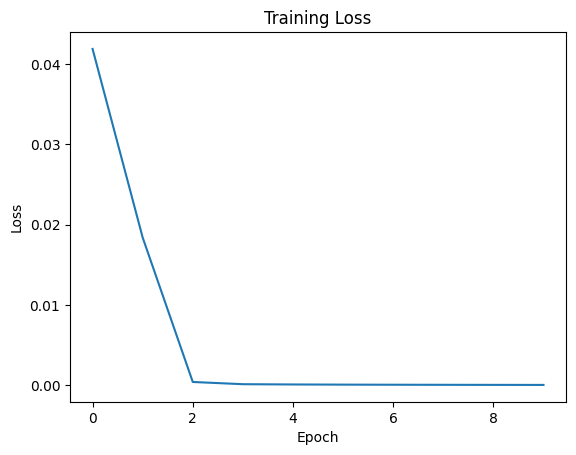

In [7]:
# Paramètres pour la création du jeu de données
num_samples = 10000          # Nombre d'échantillons à générer. Ex: 5000, 10000, 15000, etc.
min_value = 0                # Valeur minimale pour la génération de nombres. Ex: 0, 10, -10, etc.
max_value = 100              # Valeur maximale pour la génération de nombres. Ex: 100, 200, 500, etc.
operation = 'add'       # Opération à effectuer. Options : 'add' ou 'multiply'.
batch_size = 64              # Taille des lots pour l'entraînement. Ex: 32, 64, 128, etc.

# Paramètres pour le modèle MLP
input_size = 2               # Taille de l'entrée. Pour notre cas, c'est toujours 2.
hidden_size = 10             # Nombre de neurones dans les couches cachées. Ex: 10, 20, 50, etc.
output_size = 1              # Taille de la sortie. Pour notre cas, c'est toujours 1.
num_hidden_layers = 3        # Nombre de couches cachées. Ex: 1, 2, 3, 4, etc.

# Paramètres pour l'entraînement
epochs = 10                  # Nombre d'époques pour l'entraînement. Ex: 5, 10, 20, etc.


#? Création du DataLoader et initialisation du modèle
dataloader = create_calculator_dataloader(num_samples=num_samples, min_value=min_value, max_value=max_value, operation=operation, batch_size=batch_size)
model = MLP(input_size=input_size, hidden_size=hidden_size, output_size=output_size, num_hidden_layers=num_hidden_layers).to(device)


#? Entraînement du modèle
loss_history = train_model(model, dataloader, epochs=epochs, optimizer_name="sgd", lr=0.1)

# Affichage de la courbe de perte
plt.plot(loss_history)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


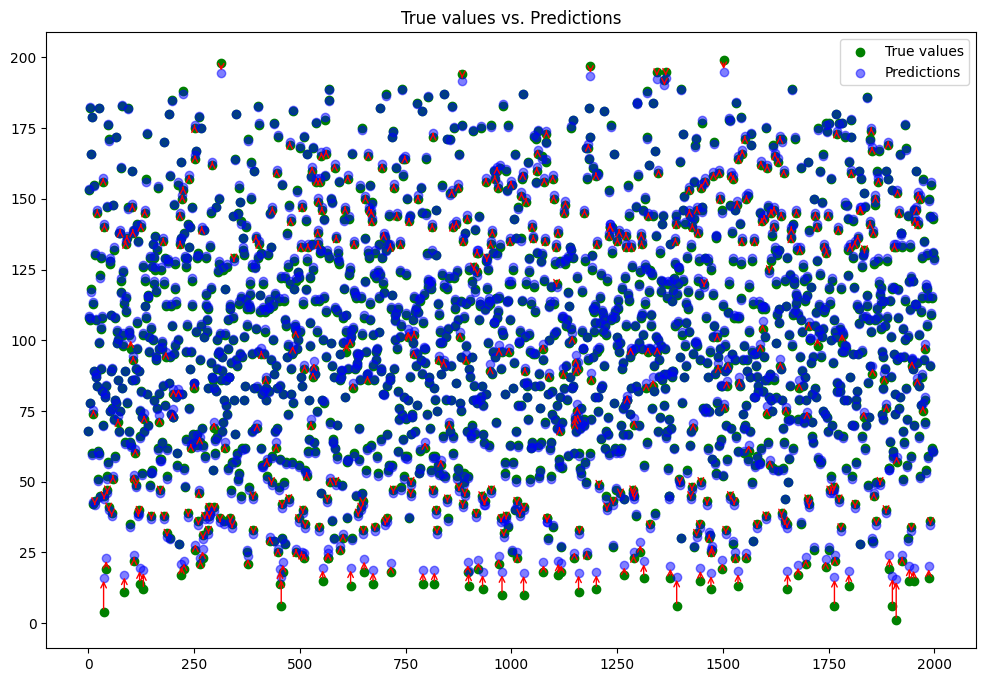

Mean Squared Error (MSE): 1.6475
Mean Absolute Error (MAE): 0.8058
R-squared (R2): 0.9990


In [8]:
#? Test et visualisation des prédictions
num_samples = 2000

y_pred, y_true = test_model(model, num_samples, min_value, max_value, operation)
plot_predictions(y_true, y_pred)

#? Évaluation des performances à l'aide de différentes métriques
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")

In [9]:
def predict_sum(model, num1, num2, max_value=100):
    # Normaliser les entrées
    X_input = torch.tensor([[num1/max_value, num2/max_value]], dtype=torch.float32).to(device)
    
    # Effectuer une inférence
    with torch.no_grad():
        prediction = model(X_input)
    
    # Dénormiliser la prédiction
    predicted_sum = prediction * (2 * max_value)  # Pour l'addition
    return predicted_sum.item()

# Test de la fonction
result = predict_sum(model, 50, 50)
print(f"La somme prédite de 5 et 5 est : {result:.2f}")


La somme prédite de 5 et 5 est : 100.39
